### Use Scipy to recompute the eigenvalues for a validation


Processing Object0...
Matrix dimensions: K (19065, 19065), M (19065, 19065)
Number of non-zero elements: K 672651, M 19065

First 10 eigenvalues:
[-3.31763632e-03 -1.99293413e-03 -3.47177365e-04  1.13931450e-03
  2.18135117e-03  4.20063208e-03  7.52028632e+09  7.56278019e+09
  2.00484321e+10  3.74493073e+10]

Validation results:
U^T M U - I error: 3.38e-14
[[-7.02430439e-04 -1.75535369e-04  8.86918815e-04  8.14791895e-04
  -9.15717479e-04]
 [-3.27096897e-04  1.03954332e-04  1.81791723e-05 -1.55183811e-04
  -3.78569059e-04]
 [ 1.03692128e-03  1.15496755e-04  1.76307610e-04 -5.24378810e-04
   5.33820856e-04]
 [ 5.67070857e-04  5.85716513e-05  5.24557102e-05 -8.01834457e-04
   1.29320896e-03]
 [ 2.43542480e-04  2.41388583e-04  9.45599949e-05  4.60130264e-04
  -3.88058158e-05]]
[[-0.00331764  0.          0.          0.          0.        ]
 [ 0.         -0.00199293  0.          0.          0.        ]
 [ 0.          0.         -0.00034718  0.          0.        ]
 [ 0.          0.        

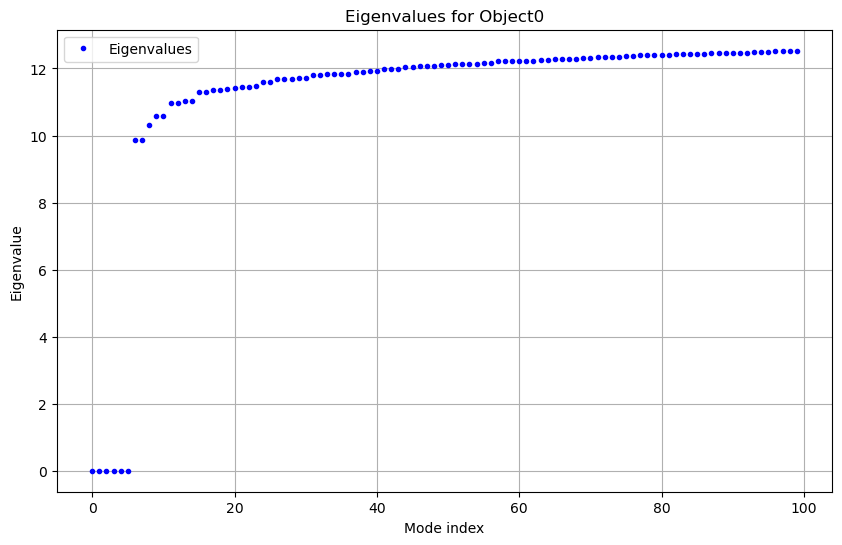

In [16]:

# load K and M from binary files and call scipy to solve the generalized eigenvalue problem

import numpy as np
from scipy import sparse
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
import os

def load_sparse_matrix(filename):
    """Load a sparse matrix saved in CSC format from binary file."""
    with open(filename, 'rb') as f:
        # Read dimensions
        rows = np.fromfile(f, dtype=np.int32, count=1)[0]
        cols = np.fromfile(f, dtype=np.int32, count=1)[0]
        nnz = np.fromfile(f, dtype=np.int32, count=1)[0]
        
        # Read the outer index pointers
        outer_indices = np.fromfile(f, dtype=np.int32, count=cols + 1)
        
        # Read the inner indices
        inner_indices = np.fromfile(f, dtype=np.int32, count=nnz)
        
        # Read the values
        values = np.fromfile(f, dtype=np.float64, count=nnz)
        
        # Construct the sparse matrix
        return sparse.csc_matrix((values, inner_indices, outer_indices), shape=(rows, cols))

def solve_generalized_eigenvalue_problem(K, M, num_modes=100, sigma=0.0):
    """Solve the generalized eigenvalue problem KU = MUS."""
    # Convert to CSR format for better performance with eigsh
    K_csr = K.tocsr()
    M_csr = M.tocsr()

    mode_min_freq = 20.0
    sigma = pow(2 * np.pi * mode_min_freq, 2)
    
    # Solve the generalized eigenvalue problem
    # Using shift-invert mode for better performance with sigma=0
    eigenvalues, eigenvectors = eigsh(
        K_csr, 
        k=num_modes,
        M=M_csr,
        sigma=sigma,
        which='LM',  # Largest Magnitude
        mode='normal'  # Solve KU = MUS directly
    )
    
    return eigenvalues, eigenvectors

def validate_solution(K, M, eigenvalues, eigenvectors):
    """Validate the solution by checking orthogonality and eigenvalue equation."""
    # Check if U^T M U = I
    UT_M_U = eigenvectors.T @ M @ eigenvectors
    identity_error = np.linalg.norm(UT_M_U - np.eye(UT_M_U.shape[0]))
    print(f"U^T M U - I error: {identity_error:.2e}")
    
    # Check if U^T K U = diag(S)
    UT_K_U = eigenvectors.T @ K @ eigenvectors
    diag_S = np.diag(eigenvalues)
    print(UT_K_U[:5, :5])
    print(diag_S[:5, :5])
    eigenvalue_error = np.linalg.norm(UT_K_U - diag_S)
    print(f"U^T K U - diag(S) error: {eigenvalue_error:.2e}")
    
    # Check if K * U = M * U * diag(S)
    K_U = K @ eigenvectors
    M_U_diag_S = M @ eigenvectors @ diag_S
    equation_error = np.linalg.norm(K_U - M_U_diag_S)
    print(f"K * U - M * U * diag(S) error: {equation_error:.2e}")
    
    return identity_error, eigenvalue_error, equation_error

def plot_eigenvalues(eigenvalues, title="Eigenvalues"):
    """Plot the eigenvalues."""
    plt.figure(figsize=(10, 6))
    plt.plot(eigenvalues, 'b.', label='Eigenvalues')
    plt.xlabel('Mode index')
    plt.ylabel('Eigenvalue')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

# Get the cache directory from environment or use default
# cache_dir = os.getenv('CACHE_DIR', '../cache')
cache_dir = "C:/Users/Zhehao/Research/SimpleModal/asset/coin/cache"

# Load matrices for each object in the cache directory
for filename in os.listdir(cache_dir):
    if filename.endswith('_K.bin'):
        obj_name = filename[:-6]  # Remove '_K.bin'
        K_file = os.path.join(cache_dir, filename)
        M_file = os.path.join(cache_dir, f"{obj_name}_M.bin")
        
        if not os.path.exists(M_file):
            print(f"Warning: No matching M file for {obj_name}")
            continue
            
        print(f"\nProcessing {obj_name}...")
        
        # Load matrices
        K = load_sparse_matrix(K_file)
        M = load_sparse_matrix(M_file)
        
        print(f"Matrix dimensions: K {K.shape}, M {M.shape}")
        print(f"Number of non-zero elements: K {K.nnz}, M {M.nnz}")
        
        # Solve eigenvalue problem
        num_modes = 100  # Same as in C++
        eigenvalues, eigenvectors = solve_generalized_eigenvalue_problem(K, M, num_modes)
        
        # Print first few eigenvalues
        print("\nFirst 10 eigenvalues:")
        print(eigenvalues[:10])
        
        # Validate solution
        print("\nValidation results:")
        validate_solution(K, M, eigenvalues, eigenvectors)
        
        # Plot eigenvalues
        plot_eigenvalues(np.log10(eigenvalues + 1), f"Eigenvalues for {obj_name}")
        
        # Save results for comparison with C++
        np.save(os.path.join(cache_dir, f"{obj_name}_eigenvalues_python.npy"), eigenvalues)
        np.save(os.path.join(cache_dir, f"{obj_name}_eigenvectors_python.npy"), eigenvectors)




### Mass of the object 

In [2]:
(np.sum(M) / 3 )

np.float64(0.007020701746543162)